# Auto Color Adjustment
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)
- Notebook: [auto_color_adjustment.ipynb](https://github.com/diegoinacio/computer-vision-notebooks/blob/master/Computer-Vision-Fundamentals/auto_color_adjustment.ipynb)
---
Methods which provide color adjustment without input parameters.

With these techniques, all result is given by the auto analysis from the input image.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import imageio

from _utils import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 0. Input RGB image
---

In [3]:
img_in = imageio.imread('../_data/aerial01.png')/255\

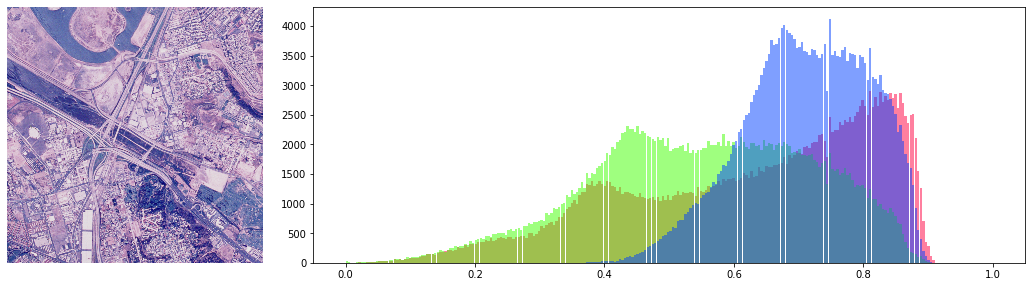

In [4]:
histogram(img_in, bins=2**8, interval=[0, 1])

In [5]:
summary(img_in)

                          R               G               B
       min:          0.0000          0.0000          0.3294
  1st Quar:          0.4784          0.4314          0.6471
    median:          0.6706          0.5569          0.7176
      mean:          0.6283          0.5505          0.7126
  3rd Quar:          0.7961          0.6824          0.7882
       max:          0.9137          0.9098          0.9059
     sigma:          0.1932          0.1693          0.0962


## 1. Equalize (Automatic contrast enhancement)
---
Automatic contrast enhancement using *histogram equalization* for each channel.

In [6]:
img_eq = img_in.copy()
# Split channels
R = img_eq[:,:,0]
G = img_eq[:,:,1]
B = img_eq[:,:,2]
# Get dimensions
N1, N2, _ = img_eq.shape
# Histogram equalization
Rs = np.sort(R.ravel())
Gs = np.sort(G.ravel())
Bs = np.sort(B.ravel())
R[:,:] = Rs.searchsorted(R)
G[:,:] = Gs.searchsorted(G)
B[:,:] = Bs.searchsorted(B)
# Feature normalization
img_eq = img_eq/(N1*N2 - 1)

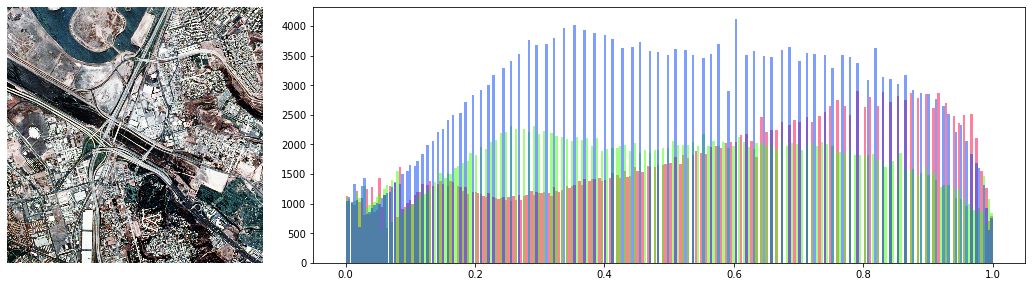

In [7]:
histogram(img_eq, bins=2**8, interval=[0, 1])

In [8]:
summary(img_eq)

                          R               G               B
       min:          0.0000          0.0000          0.0000
  1st Quar:          0.2478          0.2480          0.2425
    median:          0.4961          0.4990          0.4969
      mean:          0.4967          0.4968          0.4943
  3rd Quar:          0.7496          0.7432          0.7399
       max:          1.0000          1.0000          1.0000
     sigma:          0.2874          0.2885          0.2881


## 2. RGB component stretch
---
Feature scaling, using *min-max normalization* to stretch each channel to 0.0-1.0 range.

In [9]:
img_rgb = img_in.copy()
# Get minimum values
RGB_min = np.apply_over_axes(
    np.amin, img_rgb, [0, 1]
).ravel()
# Get maximum values
RGB_max = np.apply_over_axes(
    np.amax, img_rgb, [0, 1]
).ravel()
# min-max normalization
img_rgb = (img_rgb - RGB_min)/(RGB_max - RGB_min)

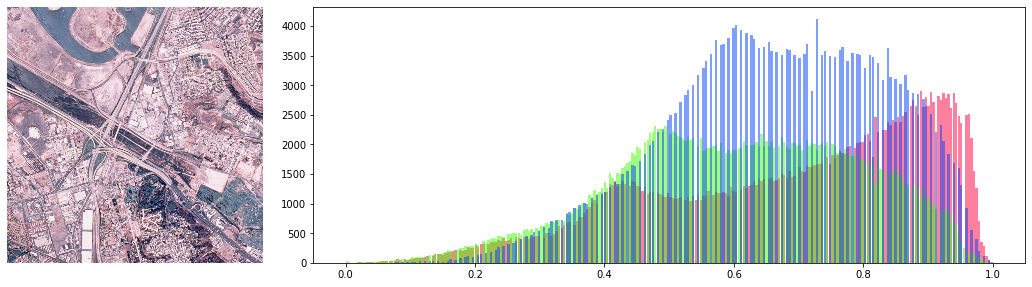

In [10]:
histogram(img_rgb, bins=2**8, interval=[0, 1])

In [11]:
summary(img_rgb)

                          R               G               B
       min:          0.0000          0.0000          0.0000
  1st Quar:          0.5236          0.4741          0.5510
    median:          0.7339          0.6121          0.6735
      mean:          0.6876          0.6050          0.6648
  3rd Quar:          0.8712          0.7500          0.7959
       max:          1.0000          1.0000          1.0000
     sigma:          0.2115          0.1861          0.1668


## 3. HSV component stretch
---
Stretch components from HSV space to 0.0-1.0 range, only preserving the *hue* channel.

In [12]:
# Convert from RGB to HSV
HSV_ = mpl.colors.rgb_to_hsv(img_in)
# Get minimum values from HSV
HSV_min = np.apply_over_axes(
    np.amin, HSV_, [0, 1]
).ravel()
# Get maximum values from HSV
HSV_max = np.apply_over_axes(
    np.amax, HSV_, [0, 1]
).ravel()
# Find delta = max - min
HSV_delta = HSV_max - HSV_min
# Preserve hue component
HSV_min[[0]] = 0
HSV_delta[0] = 1
# Stretch the components, preserving hue
HSV_ = (HSV_ - HSV_min)/HSV_delta
# Convert from HSV to RGB
img_hsv = mpl.colors.hsv_to_rgb(HSV_)

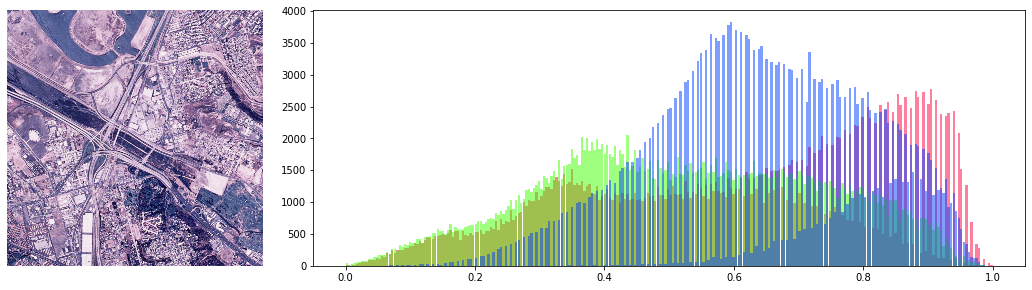

In [13]:
histogram(img_hsv, bins=2**8, interval=[0, 1])

In [14]:
summary(img_hsv)

                          R               G               B
       min:          0.0000          0.0000          0.0000
  1st Quar:          0.3963          0.3624          0.5436
    median:          0.6198          0.5154          0.6644
      mean:          0.5936          0.5208          0.6600
  3rd Quar:          0.7987          0.6886          0.7949
       max:          1.0000          0.9933          0.9890
     sigma:          0.2361          0.2109          0.1675


## 4. White balance
---
White balance based on the concept of *gray world*, where $\mu_R=\mu_G=\mu_B$.

In [15]:
# Find the mean values
R_mu, G_mu, B_mu = np.apply_over_axes(
    np.mean, img_in, [0, 1]
).ravel()
# Define the correction values based on green channel
corrR = G_mu - R_mu
corrB = G_mu - B_mu
# Offset the components to equalize all mean values
offset = img_in + [corrR, 0 ,corrB]
# Move the mean value to zero
cent = offset - G_mu
# Find the maximum values after offset
cent_max = np.apply_over_axes(
    np.amax, cent, [0, 1]
).ravel()
# Stretch and normalize values gratter than mean
img_wb = (1 - G_mu)*cent/cent_max + G_mu
# Stretch and normalize values lower than mean
cent = offset + 1 - G_mu
cent_min = np.apply_over_axes(
    np.amin, cent, [0, 1]
).ravel()
norm = 1 - (G_mu*(1 - cent)/(1 - cent_min) + 1 - G_mu)
mu_down = norm < G_mu
img_wb[mu_down] = norm[mu_down]

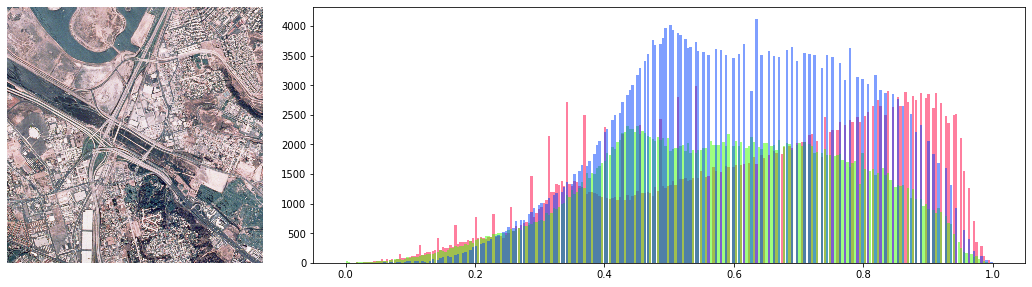

In [16]:
histogram(img_wb, bins=2**8, interval=[0, 1])

In [17]:
summary(img_wb)

                          R               G               B
       min:          0.0000          0.0000          0.0000
  1st Quar:          0.4192          0.4314          0.4563
    median:          0.6171          0.5585          0.5621
      mean:          0.6078          0.5681          0.5857
  3rd Quar:          0.8147          0.7155          0.7263
       max:          1.0000          1.0000          1.0000
     sigma:          0.2257          0.1895          0.1785


## 5. Comparison
---

Input


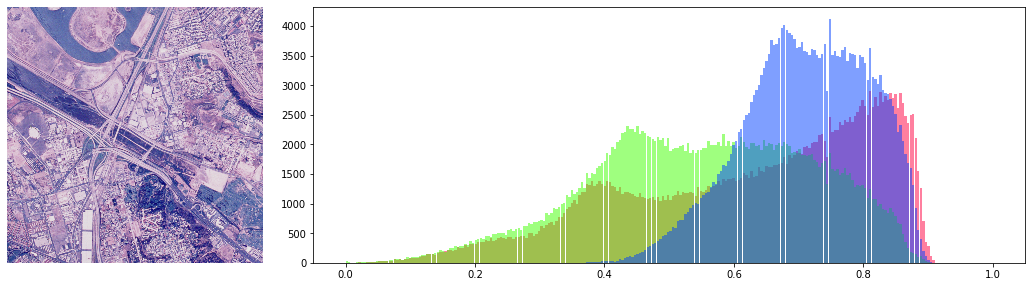

Equalize


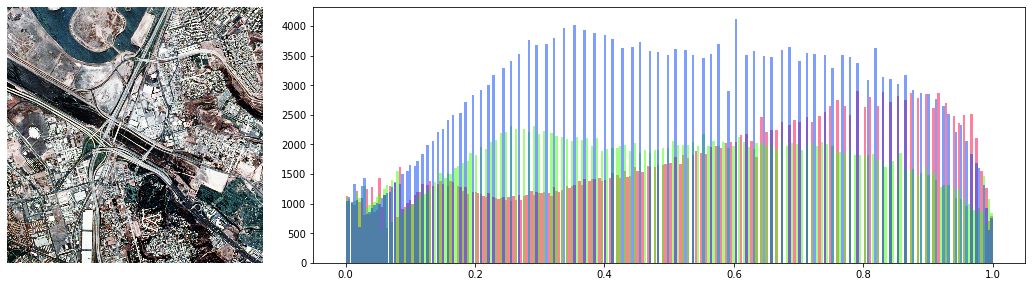

RGB component stretch


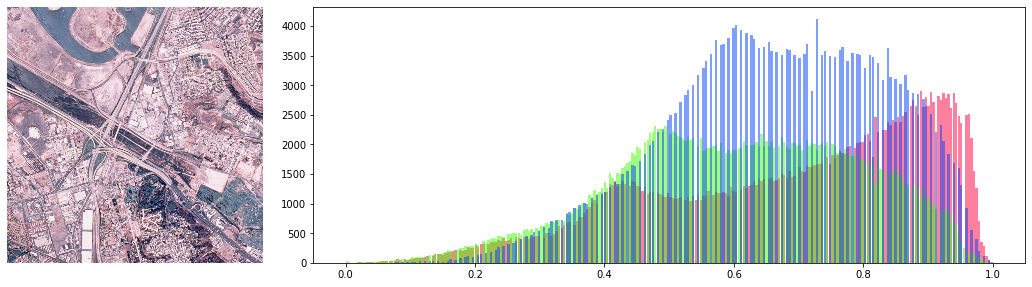

HSV component stretch


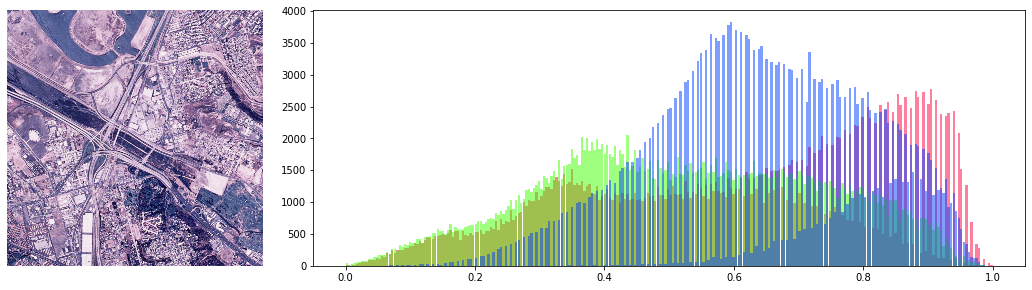

White balance


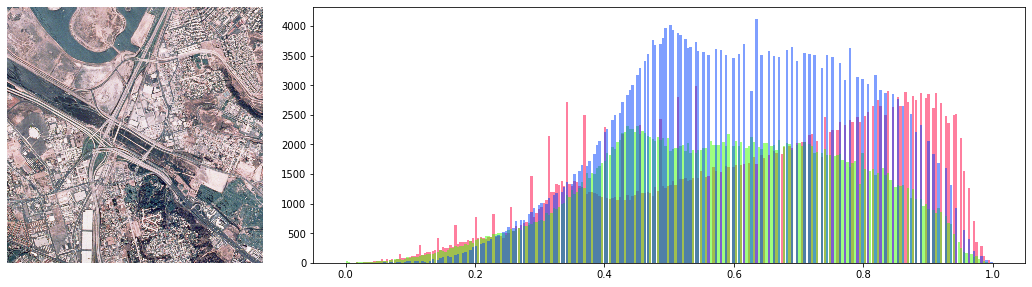

In [18]:
print('Input')
histogram(img_in, bins=2**8, interval=[0, 1])
print('Equalize')
histogram(img_eq, bins=2**8, interval=[0, 1])
print('RGB component stretch')
histogram(img_rgb, bins=2**8, interval=[0, 1])
print('HSV component stretch')
histogram(img_hsv, bins=2**8, interval=[0, 1])
print('White balance')
histogram(img_wb, bins=2**8, interval=[0, 1])